In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from cana.datasets.bio import LEUKEMIA
import re
from scipy.integrate import trapezoid

In [2]:
class Intervention:
    def __init__(self, name):
        self.name = name
        sp = name.split("_")

        if sp[0] == "EG":
            self.intervention_type = "Edgetic"
            self.source = sp[1]
            self.target = sp[2]
            self.value = int(sp[3])
        else:
            if sp[0] == "SM":
                self.intervention_type = "Stable Motif"
            elif sp[0] == "IB":
                self.intervention_type = "Mean Field"
            self.interventions = [
                x.split("=")
                for x in re.sub(
                    "anti_",
                    "_0=",
                    re.sub("pro_", "_1=", name),
                ).split(
                    "_"
                )[2:-1]
            ]

    def __repr__(self):
        return f"Intervention({self.name})"

    def __str__(self):
        if self.intervention_type == "Edgetic":
            return f"{self.intervention_type}: {self.source} -> {self.target} = {self.value}"
        else:
            return f"{self.intervention_type}: {[f'{x[1]}={x[0]}' for x in self.interventions]}"

### Load and process spatial (gradient) simulations

In [3]:
# whats going on here? Why compress to one row?
df_raw = pd.read_csv(
    "../dataframes/aggregated_live_cells_spatial.csv", index_col=0, header=None
)
df_dict = {}
for row in df_raw.iterrows():
    if row[0] == "intervention":
        name = "time (minutes)"
    else:
        name = row[0]
    df_dict[name] = [np.array(row[1])]
df = pd.DataFrame(df_dict)
df

,time (minutes),EG_Ceramide_S1P_1_11,EG_GAP_RAS_1_11,EG_IL15_GAP_0_11,EG_IL2RBT_IL2RB_0_11,EG_IL2RB_MCL1_0_11,EG_JAK_STAT3_0_11,EG_MCL1_BID_0_11,EG_PDGFR_SPHK1_0_11,EG_PI3K_ERK_0_11,...,SM_anti_PDGFR_11,SM_anti_S1P_11,SM_anti_SPHK1_11,SM_pro_Ceramidepro_GRB2_11,SM_pro_Ceramidepro_IL2RBT_11,SM_pro_Ceramidepro_IL2RB_11,SM_pro_Ceramidepro_PI3Kpro_ERK_11,SM_pro_Ceramidepro_PI3Kpro_MEK_11,SM_pro_Ceramidepro_RAS_11,SM_pro_TBETpro_Ceramidepro_ERK_11
0,"[0.0, 12.0, 24.0, 36.0, 48.0, 60.0, 72.0, 84.0...","[1344.0, 1345.0, 1345.0, 1348.0, 1352.0, 1353....","[1344.0, 1347.0, 1349.0, 1349.0, 1351.0, 1352....","[1344.0, 1345.0, 1346.0, 1347.0, 1348.0, 1350....","[1344.0, 1345.0, 1346.0, 1349.0, 1352.0, 1352....","[1344.0, 1346.0, 1350.0, 1352.0, 1352.0, 1352....","[1344.0, 1348.0, 1349.0, 1350.0, 1353.0, 1354....","[1344.0, 1345.0, 1345.0, 1348.0, 1351.0, 1355....","[1344.0, 1344.0, 1344.0, 1347.0, 1349.0, 1351....","[1344.0, 1344.0, 1345.0, 1346.0, 1347.0, 1350....",...,"[1344.0, 1346.0, 1347.0, 1350.0, 1351.0, 1351....","[1344.0, 1345.0, 1345.0, 1345.0, 1346.0, 1347....","[1344.0, 1347.0, 1350.0, 1350.0, 1350.0, 1352....","[1344.0, 1344.0, 1347.0, 1349.0, 1350.0, 1353....","[1344.0, 1346.0, 1346.0, 1347.0, 1347.0, 1347....","[1344.0, 1345.0, 1345.0, 1345.0, 1347.0, 1349....","[1344.0, 1346.0, 1352.0, 1352.0, 1354.0, 1354....","[1344.0, 1345.0, 1350.0, 1351.0, 1354.0, 1355....","[1344.0, 1344.0, 1350.0, 1351.0, 1351.0, 1352....","[1344.0, 1345.0, 1347.0, 1347.0, 1349.0, 1353...."


In [4]:
bn = LEUKEMIA()
eg = bn.effective_graph()
name_inds = {d["label"]: u for u, d in eg.nodes(data=True)}

In [5]:
def distance(eg, source, target):
    paths = list(nx.all_simple_edge_paths(eg, source, target))
    d = min(sum(1 for u, v in path) for path in paths)
    e = min(sum(1 / eg.edges[u, v]["weight"] - 1 for u, v in path) for path in paths)
    return (d, e)


distance(eg, name_inds["Ceramide"], name_inds["Apoptosis"])

(3, 1.4564459930313587)

In [6]:
dists = {}
for col in df.columns[1:]:
    inter = Intervention(col)
    if inter.intervention_type == "Edgetic":
        controlled = inter.target
    elif inter.intervention_type == "Stable Motif":
        if len(inter.interventions) > 1:
            continue
        controlled = inter.interventions[0][1]
    else:
        controlled = inter.interventions[0][1]

    dists[col] = (
        distance(eg, name_inds[controlled], name_inds["Apoptosis"]),
        name_inds[controlled],
    )

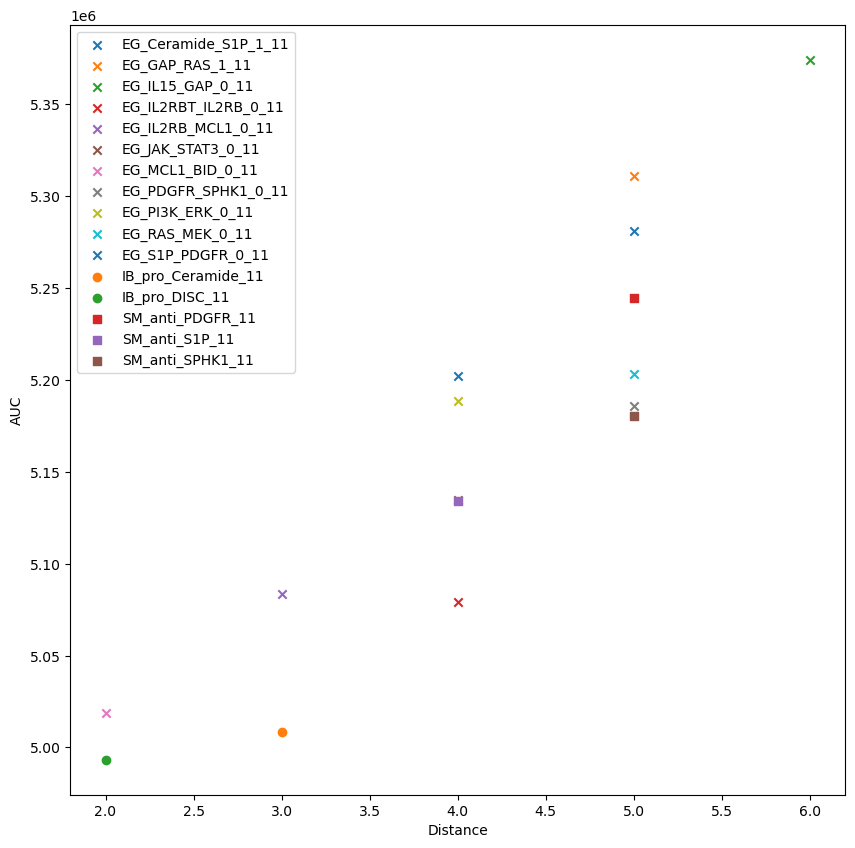

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
time_col = df.columns[0]
for col in df.columns[1:]:
    if col not in dists:
        continue
    auc = trapezoid(df[col].to_numpy()[0], x=df[time_col].to_numpy()[0])
    if auc < 9e6:
        if col[0:2] == "EG":
            marker = "x"
        elif col[0:2] == "SM":
            marker = "s"
        else:
            marker = "o"
        ax.scatter(dists[col][0][0], auc, label=col, marker=marker)

ax.set_ylabel("AUC")
ax.set_xlabel("Distance")
ax.legend()

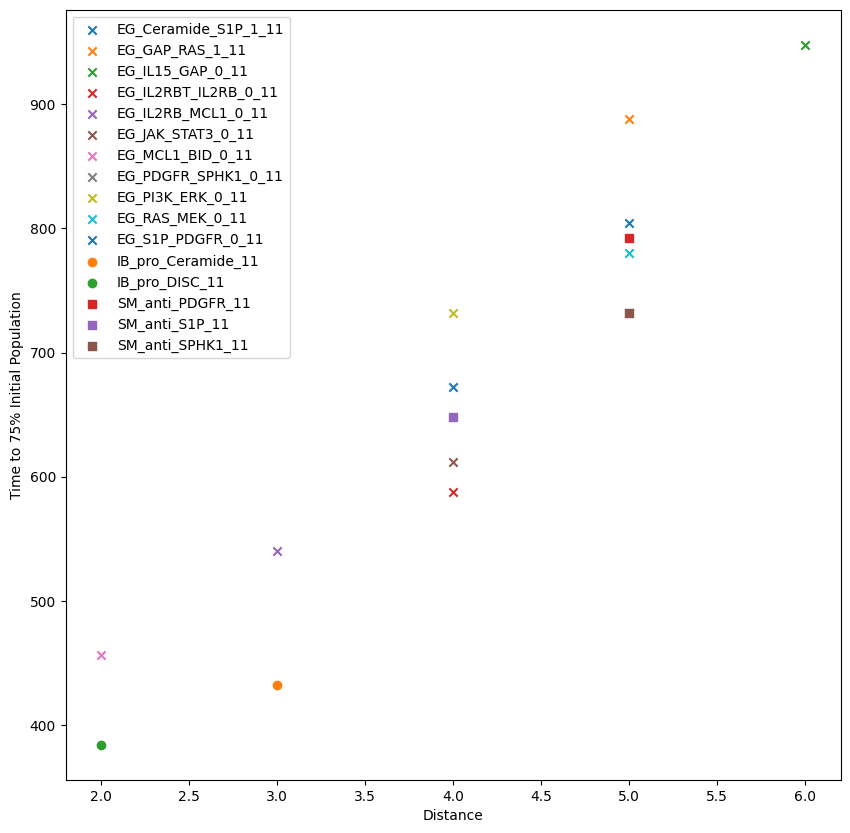

In [186]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
time_col = df.columns[0]
for col in df.columns[1:]:
    if col not in dists:
        continue
    vals = df[col].to_numpy()[0]
    t = df[time_col].to_numpy()[0]
    auc = trapezoid(vals, x=t)
    pop_ref = 1334 * 0.75

    if auc < 9e6:
        t_ref = t[min([i for i, x in enumerate(vals) if x < pop_ref])]
        if col[0:2] == "EG":
            marker = "x"
        elif col[0:2] == "SM":
            marker = "s"
        else:
            marker = "o"
        ax.scatter(dists[col][0][0], t_ref, label=col, marker=marker)


ax.set_ylabel("Time to 75% Initial Population")
ax.set_xlabel("Distance")
ax.legend()

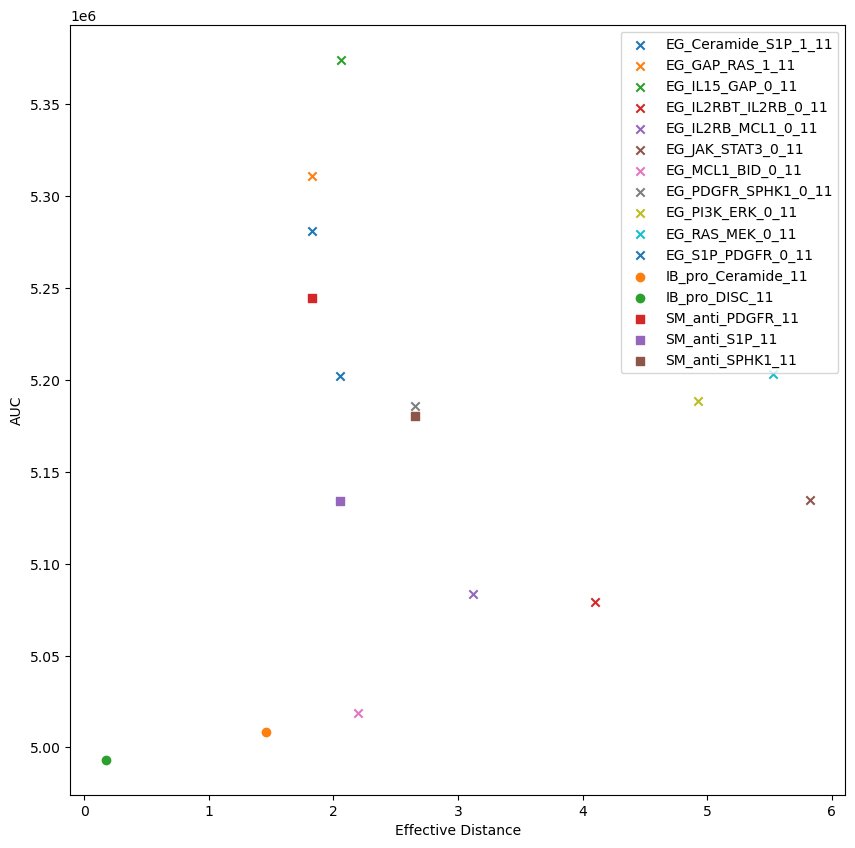

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
time_col = df.columns[0]
for col in df.columns[1:]:
    if col not in dists:
        continue
    auc = trapezoid(df[col].to_numpy()[0], x=df[time_col].to_numpy()[0])
    if auc < 9e6:
        if col[0:2] == "EG":
            marker = "x"
        elif col[0:2] == "SM":
            marker = "s"
        else:
            marker = "o"
        ax.scatter(dists[col][0][1], auc, label=col, marker=marker)

ax.set_ylabel("AUC")
ax.set_xlabel("Effective Distance")
ax.legend()

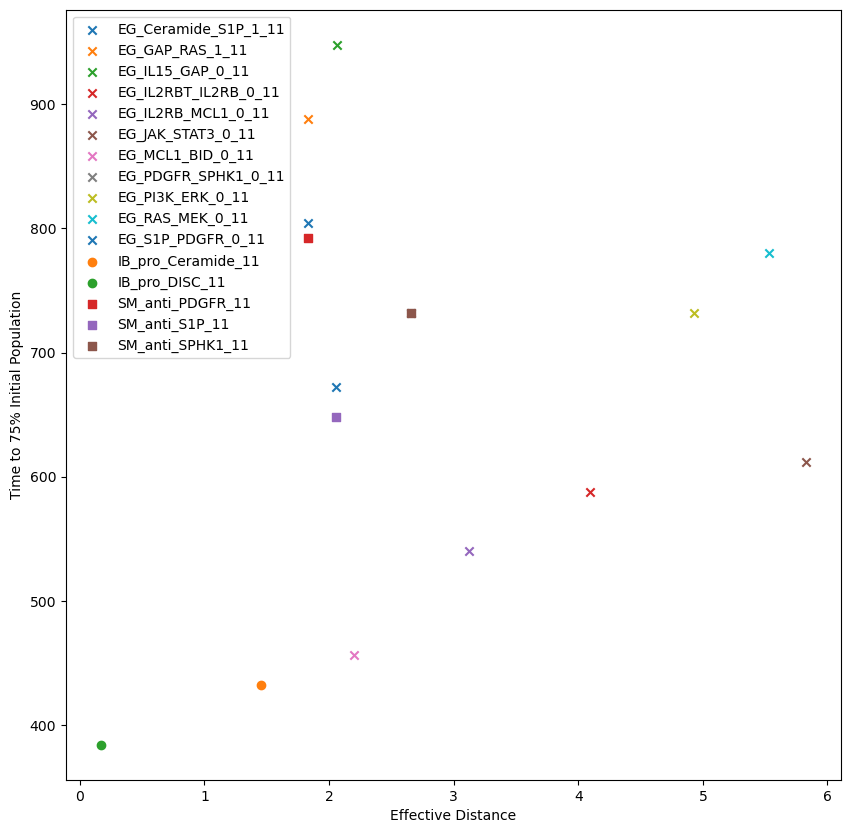

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
time_col = df.columns[0]
for col in df.columns[1:]:
    if col not in dists:
        continue
    vals = df[col].to_numpy()[0]
    t = df[time_col].to_numpy()[0]
    auc = trapezoid(vals, x=t)
    pop_ref = 1334 * 0.75

    if auc < 9e6:
        t_ref = t[min([i for i, x in enumerate(vals) if x < pop_ref])]
        if col[0:2] == "EG":
            marker = "x"
        elif col[0:2] == "SM":
            marker = "s"
        else:
            marker = "o"
        ax.scatter(dists[col][0][1], t_ref, label=col, marker=marker)


ax.set_ylabel("Time to 75% Initial Population")
ax.set_xlabel("Effective Distance")
ax.legend()

### Load time (pulsed) simulation results

In [60]:
df_raw = pd.read_csv(
    "../dataframes/aggregated_live_cells_time.csv", index_col=0,
)

df_raw = df_raw.T
# df_raw
df_avg = pd.DataFrame()

# Process columns in steps of three
for i in range(0, len(df_raw.columns), 3):
    # The base name for the averaged column can be derived from the first of each three columns,
    # removing the last digit and the underscore immediately preceding it.
    # This needs fixed - jsut need to remove the last digit
    base_name = df_raw.columns[i][:-1]  # Remove only the last character (replicate number)
    # print(base_name)
    
    # Select the three replicate columns
    replicate_cols = df_raw.iloc[:, i:i+3]
    # print(replicate_cols)
    
    # Calculate the average of these columns
    df_avg[base_name] = replicate_cols.mean(axis=1)

# add back in the integer index

df_avg.reset_index(drop=False, inplace=True)

df_avg.rename(columns={'index': 'time (minutes)'}, inplace=True)
df_avg.astype(np.float64)
df_avg['time (minutes)'] = pd.to_numeric(df_avg['time (minutes)'])
df_avg.tail()



,time (minutes),EG_Ceramide_S1P_1_1,EG_Ceramide_S1P_1_2,EG_Ceramide_S1P_1_3,EG_GAP_RAS_1_1,EG_GAP_RAS_1_2,EG_GAP_RAS_1_3,EG_IL15_GAP_0_1,EG_IL15_GAP_0_2,EG_IL15_GAP_0_3,...,SM_pro_Ceramidepro_PI3Kpro_ERK_3,SM_pro_Ceramidepro_PI3Kpro_MEK_1,SM_pro_Ceramidepro_PI3Kpro_MEK_2,SM_pro_Ceramidepro_PI3Kpro_MEK_3,SM_pro_Ceramidepro_RAS_1,SM_pro_Ceramidepro_RAS_2,SM_pro_Ceramidepro_RAS_3,SM_pro_TBETpro_Ceramidepro_ERK_1,SM_pro_TBETpro_Ceramidepro_ERK_2,SM_pro_TBETpro_Ceramidepro_ERK_3
656,7872.0,368.333333,3.000000,1.666667,2456.333333,610.666667,41.000000,2459.333333,634.333333,39.666667,...,2.0,349.333333,0.333333,0.666667,352.000000,2.0,1.666667,361.333333,3.666667,1.0
657,7884.0,366.666667,3.000000,1.666667,2456.666667,607.666667,40.666667,2459.666667,630.333333,39.666667,...,2.0,348.333333,0.333333,0.666667,352.000000,2.0,1.666667,361.000000,3.666667,1.0
658,7896.0,365.333333,2.666667,1.666667,2457.666667,604.333333,40.333333,2462.333333,626.666667,39.333333,...,2.0,346.666667,0.333333,0.666667,350.333333,2.0,1.666667,360.666667,4.000000,1.0
659,7908.0,364.666667,2.666667,1.666667,2458.666667,600.333333,40.666667,2463.000000,623.666667,39.000000,...,2.0,345.000000,0.333333,0.666667,349.666667,2.0,1.666667,358.666667,4.000000,1.0
660,7920.0,363.666667,2.666667,1.666667,2459.333333,598.333333,40.333333,2465.666667,621.000000,39.000000,...,2.0,343.333333,0.333333,0.666667,347.000000,2.0,1.666667,357.666667,4.000000,1.0


In [61]:

df_avg = df_avg.T

df_dict = {}
for row in df_avg.iterrows():
    if row[0] == "intervention":
        name = "time (minutes)"
    else:
        name = row[0]
    df_dict[name] = [np.array(row[1])]
df = pd.DataFrame(df_dict)
df

,time (minutes),EG_Ceramide_S1P_1_1,EG_Ceramide_S1P_1_2,EG_Ceramide_S1P_1_3,EG_GAP_RAS_1_1,EG_GAP_RAS_1_2,EG_GAP_RAS_1_3,EG_IL15_GAP_0_1,EG_IL15_GAP_0_2,EG_IL15_GAP_0_3,...,SM_pro_Ceramidepro_PI3Kpro_ERK_3,SM_pro_Ceramidepro_PI3Kpro_MEK_1,SM_pro_Ceramidepro_PI3Kpro_MEK_2,SM_pro_Ceramidepro_PI3Kpro_MEK_3,SM_pro_Ceramidepro_RAS_1,SM_pro_Ceramidepro_RAS_2,SM_pro_Ceramidepro_RAS_3,SM_pro_TBETpro_Ceramidepro_ERK_1,SM_pro_TBETpro_Ceramidepro_ERK_2,SM_pro_TBETpro_Ceramidepro_ERK_3
0,"[0.0, 12.0, 24.0, 36.0, 48.0, 60.0, 72.0, 84.0...","[1500.0, 1503.0, 1504.3333333333333, 1506.6666...","[1500.0, 1502.0, 1502.6666666666667, 1504.3333...","[1500.0, 1501.3333333333333, 1502.0, 1502.6666...","[1500.0, 1500.3333333333333, 1502.333333333333...","[1500.0, 1501.0, 1502.3333333333333, 1504.6666...","[1500.0, 1500.6666666666667, 1502.0, 1503.3333...","[1500.0, 1502.0, 1502.6666666666667, 1504.0, 1...","[1500.0, 1501.3333333333333, 1502.0, 1502.6666...","[1500.0, 1501.3333333333333, 1503.666666666666...",...,"[1500.0, 1502.3333333333333, 1504.666666666666...","[1500.0, 1501.3333333333333, 1502.666666666666...","[1500.0, 1501.3333333333333, 1502.666666666666...","[1500.0, 1501.0, 1502.6666666666667, 1504.3333...","[1500.0, 1500.6666666666667, 1501.333333333333...","[1500.0, 1501.3333333333333, 1502.333333333333...","[1500.0, 1500.6666666666667, 1503.0, 1505.3333...","[1500.0, 1501.6666666666667, 1504.0, 1506.0, 1...","[1500.0, 1501.0, 1502.3333333333333, 1503.6666...","[1500.0, 1502.6666666666667, 1504.333333333333..."


Text(0.5, 0, 'AUC')

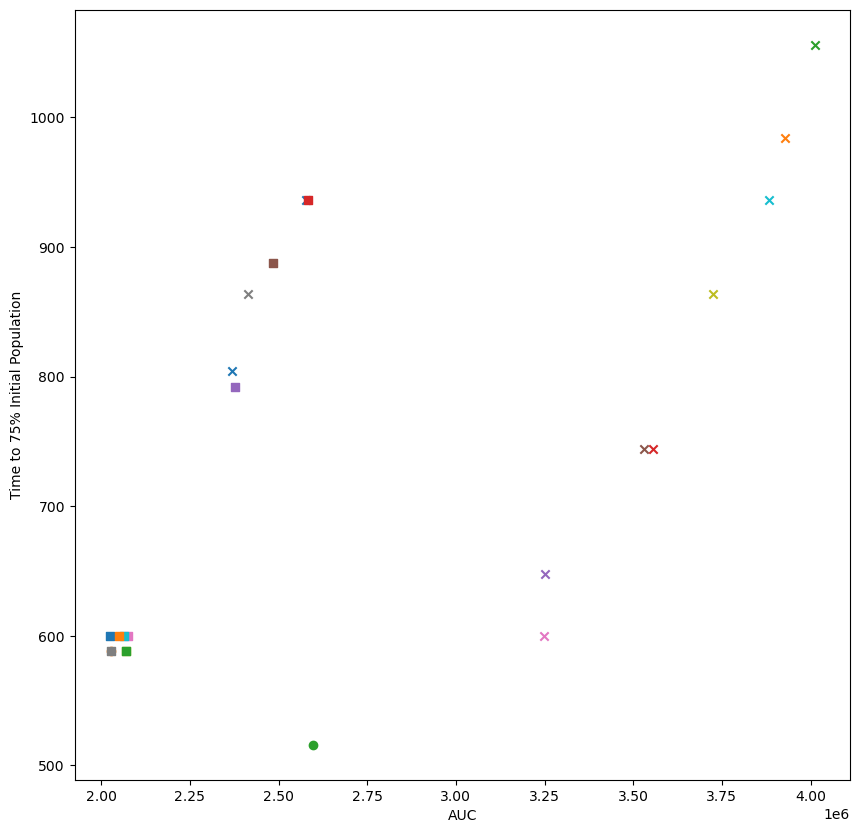

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
time_col = df.columns[0]
for col in df.columns[1:]:
    vals = df[col].to_numpy()[0]
    t = df[time_col].to_numpy()[0]
    auc = trapezoid(vals, x=t)
    pop_ref = 1500 * 0.75

    if col[-1] == "3":
        try:
            t_ref = t[min([i for i, x in enumerate(vals) if x < pop_ref])]
        except:
            continue
        if col[0:2] == "EG":
            marker = "x"
        elif col[0:2] == "SM":
            marker = "s"
        else:
            marker = "o"
        ax.scatter(auc, t_ref, label=col, marker=marker)


ax.set_ylabel("Time to 75% Initial Population")
ax.set_xlabel("AUC")